![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [130]:
import warnings
warnings.filterwarnings('ignore')

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from talib import RSI, BBANDS, MACD, NATR, ATR
from scipy.stats import spearmanr, norm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from AlgorithmImports import *
import seaborn as sns
idx = pd.IndexSlice
qb = QuantBook()

In [179]:
symbols = {}
assets = ["SHY", "TLT", "SHV", "TLH", "EDV", "BIL",
          "SPTL", "TBT", "TMF", "TMV", "TBF", "VGSH", "VGIT",
          "VGLT", "SCHO", "SCHR", "SPTS", "GOVT", 'SPY']

for i in range(len(assets)):
    symbols[assets[i]] = qb.AddEquity(assets[i],Resolution.Minute).Symbol

qb.SetStartDate(2018, 1, 1)

qb.AddUniverse(CoarseSelectionFunction, FineSelectionFunction)
df = qb.History(qb.Securities.Keys, 2*360, resolution=Resolution.Daily)
df.dropna(inplace=True)

df.head()

close       high        low       open  \
symbol           time                                                     
SHY SGNKIKYGE9NP 2015-02-25  76.411928  76.411928  76.294732  76.321777   
                 2015-02-26  76.402913  76.402913  76.366853  76.366853   
                 2015-02-27  76.321777  76.366853  76.321777  76.366853   
                 2015-02-28  76.366853  76.375868  76.339808  76.357838   
                 2015-03-03  76.312737  76.357834  76.303718  76.357834   

                                volume  
symbol           time                   
SHY SGNKIKYGE9NP 2015-02-25   516079.0  
                 2015-02-26   523961.0  
                 2015-02-27   533214.0  
                 2015-02-28  3279656.0  
                 2015-03-03  3579083.0

In [176]:
df['rsi'] = df.groupby('symbol').close.apply(RSI)

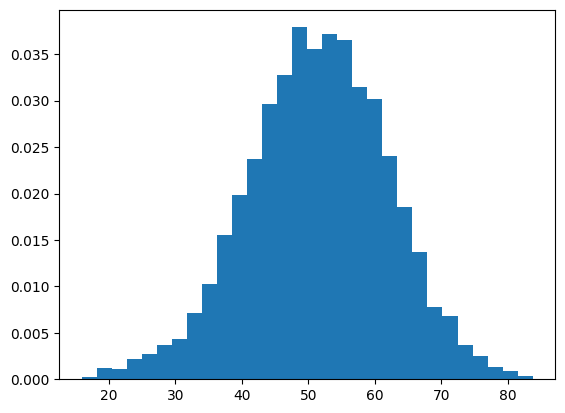

In [178]:
plt.hist(df['rsi'], bins=30, density=True);